In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import numpy as np
import os
import sys
import time
import pandas as pd 
from tqdm.notebook import tqdm_notebook
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import logging
# from src.utils import merge_simultanous_rows, save_to_blob, data_process

In [23]:
params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 5,
    "lr": 0.00010000,
    "time_steps": 60
}

iter_changes = "dropout_layers_0.4_0.4"

# INPUT_PATH = PATH_TO_DRIVE_ML_DATA+"/inputs"
# OUTPUT_PATH = PATH_TO_DRIVE_ML_DATA+"/outputs/lstm_best_7-3-19_12AM/"+iter_changes
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]

In [24]:
INPUT_PATH = "../data/ge_us_kaggle/"
OUTPUT_PATH = "../data/ge_us_kaggle/outputs/"
df_ge = pd.read_csv(os.path.join(INPUT_PATH, "ge.us.txt"), engine='python')
df_ge.tail()

,Date,Open,High,Low,Close,Volume,OpenInt
14053,2017-11-06,20.52,20.530,20.08,20.13,60641787,0
14054,2017-11-07,20.17,20.250,20.12,20.21,41622851,0
14055,2017-11-08,20.21,20.320,20.07,20.12,39672190,0
14056,2017-11-09,20.04,20.071,19.85,19.99,50831779,0
14057,2017-11-10,19.98,20.680,19.90,20.49,100698474,0


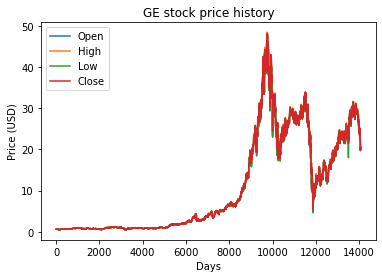

In [25]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(df_ge["Open"])
plt.plot(df_ge["High"])
plt.plot(df_ge["Low"])
plt.plot(df_ge["Close"])
plt.title('GE stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

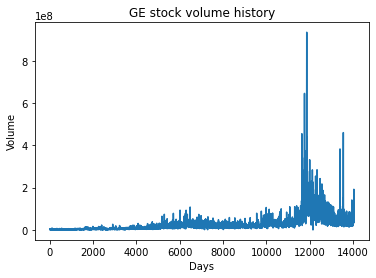

In [26]:
plt.figure()
plt.plot(df_ge["Volume"])
plt.title('GE stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

In [27]:
print("checking if any null values are present\n", df_ge.isna().sum())

checking if any null values are present
 Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64


In [28]:
def build_timeseries(mat, y_col_index):
    """
    Converts ndarray into timeseries format and supervised data format. Takes first TIME_STEPS
    number of rows as input and sets the TIME_STEPS+1th data as corresponding output and so on.
    :param mat: ndarray which holds the dataset
    :param y_col_index: index of column which acts as output
    :return: returns two ndarrays-- input and output in format suitable to feed
    to LSTM.
    """
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    print("dim_0",dim_0)
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
#         if i < 10:
#           print(i,"-->", x[i,-1,:], y[i])
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [29]:
def trim_dataset(mat,batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [30]:
# tqdm_notebook.pandas('Processing...')
# df_ge = process_dataframe(df_ge)
print(df_ge.dtypes)
train_cols = ["Open","High","Low","Close","Volume"]
df_train, df_test = train_test_split(df_ge, train_size=0.8, test_size=0.2, shuffle=False)
print("Train--Test size", len(df_train), len(df_test))

# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

Date        object
Open       float64
High       float64
Low        float64
Close      float64
Volume       int64
OpenInt      int64
dtype: object
Train--Test size 11246 2812


In [31]:
x

array([[6.2770000e-01, 6.3620000e-01, 6.2010000e-01, 6.2010000e-01,
        2.5755790e+06],
       [6.2010000e-01, 6.2010000e-01, 6.1220000e-01, 6.2010000e-01,
        1.7647490e+06],
       [6.2010000e-01, 6.2010000e-01, 6.0370000e-01, 6.1220000e-01,
        2.1940100e+06],
       ...,
       [2.7292000e+01, 2.7412000e+01, 2.7277000e+01, 2.7382000e+01,
        1.7784600e+07],
       [2.7254000e+01, 2.7718000e+01, 2.7180000e+01, 2.7718000e+01,
        2.6709564e+07],
       [2.7718000e+01, 2.7963000e+01, 2.7680000e+01, 2.7912000e+01,
        2.7934131e+07]])

In [32]:
print("Deleting unused dataframes of total size(KB)",(sys.getsizeof(df_ge)+sys.getsizeof(df_train)+sys.getsizeof(df_test))//1024)

del df_ge
del df_test
del df_train
del x

Deleting unused dataframes of total size(KB) 3267


In [33]:
x_train[0]
x_t, y_t = build_timeseries(x_train, 3)
x_t.shape

dim_0 11186



length of time-series i/o (11186, 60, 5) (11186,)


(11186, 60, 5)

In [34]:
print("Are any NaNs present in train/test matrices?",np.isnan(x_train).any(), np.isnan(x_train).any())
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
print("Batch trimmed size",x_t.shape, y_t.shape)

Are any NaNs present in train/test matrices? False False
dim_0 11186



length of time-series i/o (11186, 60, 5) (11186,)
Batch trimmed size (11180, 60, 5) (11180,)


In [35]:
def create_model():
    lstm_model = Sequential()
    # (batch_size, timesteps, data_dim)
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                        dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(LSTM(60, dropout=0.0))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(Dense(20,activation='relu'))
    lstm_model.add(Dense(1,activation='sigmoid'))
    optimizer = optimizers.RMSprop(lr=params["lr"])
    # optimizer = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    return lstm_model

In [36]:
model = None
try:
    model = pickle.load(open("lstm_model", 'rb'))
    print("Loaded saved model...")
except FileNotFoundError:
    print("Model not found")

EOFError: Ran out of input

In [37]:
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)
print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)
    

dim_0 2752



length of time-series i/o (2752, 60, 5) (2752,)
Test size (1370, 60, 5) (1370,) (1370, 60, 5) (1370,)


In [38]:
is_update_model = True
if model is None or is_update_model:
    from keras import backend as K
    print("Building model...")
#     print("checking if GPU available", K.tensorflow_backend._get_available_gpus())
    model = create_model()
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                       patience=40, min_delta=0.0001)
    
    mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,
                          "best_model.h5"), monitor='val_loss', verbose=1,
                          save_best_only=True, save_weights_only=False, mode='min', period=1)

    # Not used here. But leaving it here as a reminder for future
    r_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, 
                                  verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    
    csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'training_log_' + time.ctime().replace(" ","_").replace(":","_") + '.log'), append=True)
    
    history = model.fit(x_t, y_t, epochs=params["epochs"], verbose=2, batch_size=BATCH_SIZE,
                        shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                        trim_dataset(y_val, BATCH_SIZE)), callbacks=[es, mcp, csv_logger])
    
    print("saving model...")
#     pickle.dump(model, open("lstm_model", "wb"))

Building model...
Epoch 1/5
559/559 - 34s - loss: 0.0174 - val_loss: 0.0086

Epoch 00001: val_loss improved from inf to 0.00862, saving model to ../data/ge_us_kaggle/outputs\best_model.h5
Epoch 2/5


KeyboardInterrupt: 

In [26]:
model

In [35]:
# model.evaluate(x_test_t, y_test_t, batch_size=BATCH_SIZE
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])



Error is 0.0013108089588605286 (1360,) (1360,)
[0.3874146  0.38732716 0.38730443 0.38708764 0.3868298  0.38665572
 0.38650745 0.3862519  0.386077   0.38592598 0.38590872 0.38616675
 0.38583305 0.3854058  0.38506535]
[0.32378063 0.32499919 0.32800358 0.32905407 0.32905407 0.33031465
 0.32943225 0.33205846 0.32659593 0.32747834 0.31770881 0.31092267
 0.31258244 0.32378063 0.32592362]
[18.898787 18.894625 18.893541 18.883224 18.87095  18.862665 18.855608
 18.843445 18.83512  18.827932 18.82711  18.839392 18.82351  18.803173
 18.786968]
[15.87  15.928 16.071 16.121 16.121 16.181 16.139 16.264 16.004 16.046
 15.581 15.258 15.337 15.87  15.972]


Error is 0.0013806269146593734 (1360,) (1360,)
[0.39414594 0.39405537 0.39396402 0.39367312 0.39347526 0.39326194
 0.3930657  0.39281115 0.39259958 0.39241716 0.39240378 0.3929605
 0.39265734 0.39223102 0.39182454]
[0.32378063 0.32499919 0.32800358 0.32905407 0.32905407 0.33031465
 0.32943225 0.33205846 0.32659593 0.32747834 0.31770881 0.31092267
 0.31258244 0.32378063 0.32592362]
[19.219177 19.214867 19.210518 19.196672 19.187256 19.177101 19.16776
 19.155645 19.145575 19.136892 19.136255 19.162754 19.148325 19.128033
 19.108686]
[15.87  15.928 16.071 16.121 16.121 16.181 16.139 16.264 16.004 16.046
 15.581 15.258 15.337 15.87  15.972]


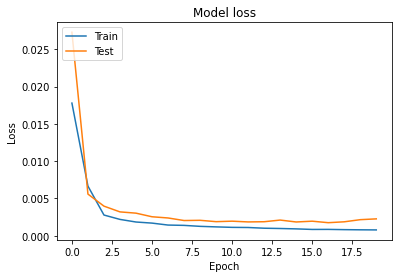

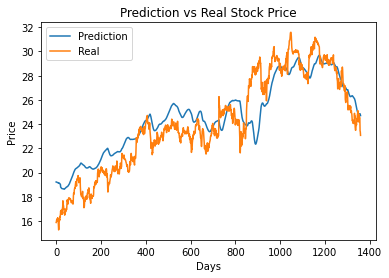

In [36]:
# Visualize the training data
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'train_vis_BS_'+str(BATCH_SIZE)+"_"+time.ctime().replace(":","_")+'.png'))

# load the saved best model from above
saved_model = load_model(os.path.join(OUTPUT_PATH, 'best_model.h5')) # , "lstm_best_7-3-19_12AM",
print(saved_model)

y_pred = saved_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
#plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(BATCH_SIZE)+"_"+time.ctime().replace(":","_")+'.png'))
# print_time("program completed ", stime)


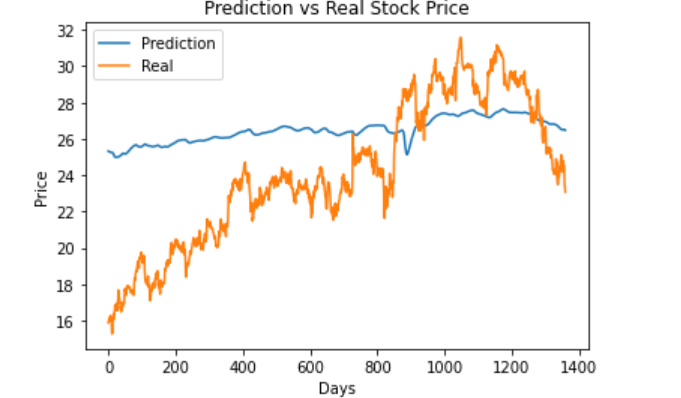

In [34]:
len(df_esv_data[df_esv_data['Date']<'2018-01-01'])

251

# LSTM Classification

In [42]:
# lstm model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical
from matplotlib import pyplot

# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
	print(trainX.shape, trainy.shape)
	# load all test
	testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
	print(testX.shape, testy.shape)
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	print(trainX.shape, trainy.shape, testX.shape, testy.shape)
	return trainX, trainy, testX, testy

# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
	verbose, epochs, batch_size = 0, 15, 64
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	model = Sequential()
	model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
	model.add(Dropout(0.5))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return accuracy

# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))


In [ ]:
# run an experiment
def run_experiment(repeats=10):
	# load data
	trainX, trainy, testX, testy = load_dataset(prefix = '../data/')
	# repeat experiment
	scores = list()
	for r in range(repeats):
		score = evaluate_model(trainX, trainy, testX, testy)
		score = score * 100.0
		print('>#%d: %.3f' % (r+1, score))
		scores.append(score)
	# summarize results
	summarize_results(scores)

# run the experiment
run_experiment()

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
>#1: 89.074
>#2: 90.838


In [40]:
# load a list of files into a 3D array of [samples, timesteps, features]
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded

In [41]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

In [28]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
	print(trainX.shape, trainy.shape)
	# load all test
	testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
	print(testX.shape, testy.shape)
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	print(trainX.shape, trainy.shape, testX.shape, testy.shape)
	return trainX, trainy, testX, testy

,#RIC,Date-Time,Bid Price,Bid Size,Ask Price,Ask Size,Seq. No.,Exch Time
213144,ESU8,2017-11-01T07:13:28.455955292-05,2521.25,1,NaN,NaN,4463647,NaN
213755,ESU8,2017-11-01T12:59:51.358262045-05,2521.25,1,2580.25,10.0,5843592,NaN
213756,ESU8,2017-11-01T12:59:51.358262045-05,2521.25,1,NaN,NaN,5843593,NaN
214043,ESU8,2017-11-01T15:37:49.377756715-05,2521.25,1,NaN,NaN,6469040,NaN
1604600,ESZ7,2017-11-01T17:26:29.298635772-05,2572.50,60,2573.00,117.0,6502223,NaN
1726273,ESZ8,2017-11-01T12:59:51.361554586-05,2560.00,1,NaN,NaN,5843596,NaN
1726296,ESZ8,2017-11-01T15:00:39.453307302-05,2560.00,1,NaN,NaN,6413566,NaN
1726316,ESZ8,2017-11-01T19:15:53.947454529-05,2560.00,1,2580.00,16.0,6545332,NaN
1726320,ESZ8,2017-11-01T19:18:05.607043466-05,2560.00,1,2577.75,16.0,6550878,NaN


In [10]:
df_1day_merged = df_1day_raw_quotes.groupby('Date-Time').agg({'Bid Price': 'max',
                                                               'Ask Price': 'min',
                                                               'Bid Size': 'sum',
                                                               'Ask Size': 'sum',
                                                               'Seq. No.': 'min',
                                                               'Exch Time': 'min',
                                                               '#RIC': 'min',})

TypeError: '<=' not supported between instances of 'str' and 'float'

In [13]:
df_1day_raw_quotes.head()

,#RIC,Date-Time,Bid Price,Bid Size,Ask Price,Ask Size,Seq. No.,Exch Time
0,ESH8,2017-11-01T00:00:00.942273191-05,2576.5,6,2577.00,4.0,4144650,05:00:00.937000000
1,ESH8,2017-11-01T00:00:00.958321667-05,2576.5,6,2577.25,14.0,4144652,04:59:48.181000000
2,ESH8,2017-11-01T00:00:27.362887060-05,2576.5,6,2577.00,4.0,4144713,05:00:27.356000000
3,ESH8,2017-11-01T00:00:27.366751371-05,2576.5,6,2577.25,14.0,4144714,04:59:48.181000000
4,ESH8,2017-11-01T00:00:34.986240724-05,2576.5,6,2577.00,4.0,4144725,05:00:34.981000000


In [17]:
df_1day_raw_quotes.dtypes

#RIC          object
Date-Time     object
Bid Price    float64
Bid Size       int64
Ask Price    float64
Ask Size     float64
Seq. No.       int64
Exch Time     object
dtype: object

In [16]:
df_1day_raw_quotes = df_1day_raw_quotes.astype({'#RIC': 'str', 'Bid Price'})

In [76]:
print("original shape of data: {}".format(
    df_1day_raw_quotes.shape))
date = os.path.basename(raw_quotes_path).split(".")[0]
today_esv = df_esv_data.loc[df_esv_data['Date']
                                    == date, 'ESV'].values[0].strip()

df_1day_raw_quotes = df_1day_raw_quotes[df_1day_raw_quotes['#RIC'] == today_esv]
print("shape of data after selecting one RIC: {}".format(
    df_1day_raw_quotes.shape))

original shape of data: (4199196, 11)
shape of data after selecting one RIC: (3697610, 11)


In [77]:
df_1day_raw_quotes.reset_index(level=0,inplace=True)
print("shape of data after reestting index: {}".format(
    df_1day_raw_quotes.shape))
df_1day_raw_quotes = df_1day_raw_quotes.loc[:10000, :]
print("shape of data after taking a slice: {}".format(
    df_1day_raw_quotes.shape))

shape of data after reestting index: (3697610, 12)
shape of data after taking a slice: (10001, 12)


In [78]:
# Clean Trade Data- remove rows with negative dollar value
cleaning_cols = ['Bid Price', 'Ask Price']
df_1day_raw_quotes[cleaning_cols] = df_1day_raw_quotes[cleaning_cols].apply(lambda x:np.where(x<=0, np.nan,x))
df_1day_raw_quotes.dropna(axis=0, inplace=True, subset=cleaning_cols)


print("shape of data after removing negative  values: {}".format(
    df_1day_raw_quotes.shape))
df_1day_raw_quotes['Date-Time'] = pd.to_datetime(df_1day_raw_quotes['Date-Time'])
df_1day_raw_quotes.head()

shape of data after removing negative  values: (10001, 12)


,index,#RIC,Alias Underlying RIC,Domain,Date-Time,Type,Bid Price,Bid Size,Ask Price,Ask Size,Seq. No.,Exch Time
0,768,ESM8,NaN,Market Price,2018-03-26 00:00:00.137799458-05:00,Quote,2611.0,12.0,2611.25,3.0,703866,05:00:00.129000000
1,769,ESM8,NaN,Market Price,2018-03-26 00:00:00.593836650-05:00,Quote,2611.0,12.0,2611.25,4.0,703882,05:00:00.587000000
2,770,ESM8,NaN,Market Price,2018-03-26 00:00:01.021872855-05:00,Quote,2611.0,12.0,2611.25,5.0,703893,05:00:01.015000000
3,771,ESM8,NaN,Market Price,2018-03-26 00:00:01.149905303-05:00,Quote,2611.0,11.0,2611.25,5.0,703896,05:00:01.145000000
4,772,ESM8,NaN,Market Price,2018-03-26 00:00:01.193911110-05:00,Quote,2611.0,10.0,2611.25,5.0,703898,05:00:01.189000000


In [79]:
df_1day_quotes_merged = df_1day_raw_quotes.groupby('Date-Time').agg({'Bid Price': 'mean',
                                                                    'Ask Price': 'mean',
                                                                    'Bid Size': 'sum',
                                                                     'Ask Size':'sum',
                                                                     'Seq. No.':'min',
                                                                     'Exch Time':'min',
                                                                     '#RIC':'min'})
print("shape of data after merging simultanous quotes: {}".format(
    df_1day_quotes_merged.shape))
df_1day_quotes_merged.head()

shape of data after merging simultanous quotes: (3917, 7)


,Bid Price,Ask Price,Bid Size,Ask Size,Seq. No.,Exch Time,#RIC
Date-Time,,,,,,,
2018-03-26 00:00:00.137799458-05:00,2611.0,2611.25,12.0,3.0,703866,05:00:00.129000000,ESM8
2018-03-26 00:00:00.593836650-05:00,2611.0,2611.25,12.0,4.0,703882,05:00:00.587000000,ESM8
2018-03-26 00:00:01.021872855-05:00,2611.0,2611.25,12.0,5.0,703893,05:00:01.015000000,ESM8
2018-03-26 00:00:01.149905303-05:00,2611.0,2611.25,11.0,5.0,703896,05:00:01.145000000,ESM8
2018-03-26 00:00:01.193911110-05:00,2611.0,2611.25,10.0,5.0,703898,05:00:01.189000000,ESM8


In [80]:
df_1day_quotes_merged.reset_index(level=0, inplace=True)
df_1day_quotes_merged.head()

,Date-Time,Bid Price,Ask Price,Bid Size,Ask Size,Seq. No.,Exch Time,#RIC
0,2018-03-26 00:00:00.137799458-05:00,2611.0,2611.25,12.0,3.0,703866,05:00:00.129000000,ESM8
1,2018-03-26 00:00:00.593836650-05:00,2611.0,2611.25,12.0,4.0,703882,05:00:00.587000000,ESM8
2,2018-03-26 00:00:01.021872855-05:00,2611.0,2611.25,12.0,5.0,703893,05:00:01.015000000,ESM8
3,2018-03-26 00:00:01.149905303-05:00,2611.0,2611.25,11.0,5.0,703896,05:00:01.145000000,ESM8
4,2018-03-26 00:00:01.193911110-05:00,2611.0,2611.25,10.0,5.0,703898,05:00:01.189000000,ESM8


# Merging Trades

In [55]:
df_1day_raw_trades = pd.read_csv(raw_trades_path, compression='gzip')
df_1day_raw_trades.head()

FileNotFoundError: [Errno 2] No such file or directory: '../../data/test/raw/2018-03-26-mts.pkl'

In [21]:
print("shape of data before selecting one RIC: {}".format(
    df_1day_raw_trades.shape))
df_1day_raw_trades=df_1day_raw_trades[df_1day_raw_trades['#RIC']==today_esv]
print("shape of data after selecting one RIC: {}".format(
    df_1day_raw_trades.shape))
# Clean Trade Data- remove rows with negative dollar value
cleaning_cols = ['Price','Volume']
df_1day_raw_trades[cleaning_cols] = df_1day_raw_trades[cleaning_cols].apply(lambda x:np.where(x<=0, np.nan,x))
df_1day_raw_trades.dropna(inplace=True, subset=cleaning_cols)
print("shape of data after removing negative  values: {}".format(
    df_1day_raw_trades.shape))

shape of data before selecting one RIC: (367888, 10)
shape of data after selecting one RIC: (366244, 10)
shape of data after removing negative  values: (365709, 10)


In [ ]:
df_1day_raw_trades = df_1day_raw_trades.groupby('Date-Time').agg({'Bid Price': 'mean',
                                                                    'Ask Price': 'mean',
                                                                    'Bid Size': 'sum',
                                                                     'Ask Size':'sum',
                                                                     'Seq. No.':'min',
                                                                     'Exch Time':'min',
                                                                     '#RIC':'min'})
print("shape of data after merging simultanous quotes: {}".format(
    df_1day_quotes_merged.shape))

In [ ]:
# cleaner = data_process()
# cleaner.detect_outliers(df_1day_raw, 40, 6, 'Price')
# df_1day_raw_quotes[cleaning_cols] = df_1day_raw_quotes[cleaning_cols].apply(lambda x:df_1day_raw)

In [8]:
# df_1day = pd.read_csv('/home/erfan/Dropbox/Futures_ML_Project/output/clean_data/ES/1T/2017-02-01.csv')

In [9]:
# df_1day_raw.drop(columns=['#RIC', 'Acc. Volume', 'Domain', 'Alias Underlying RIC', 'Type'], inplace=True)

In [10]:
# df_1day_raw = df_1day_raw.loc[:20, :]
df_1day_raw['Date-Time'] = pd.to_datetime(df_1day_raw['Date-Time'])



In [12]:
df_1day_raw.head(10)

,Date-Time,Price,Volume,Seq. No.,Exch Time
0,2018-02-02 00:00:00.160596759-06:00,2817.00,1.0,27868077,06:00:00.153000000
1,2018-02-02 00:00:00.197269762-06:00,2817.00,1.0,27868078,06:00:00.191000000
2,2018-02-02 00:00:00.269259589-06:00,2817.00,1.0,27868079,06:00:00.262000000
3,2018-02-02 00:00:00.289277601-06:00,2817.00,1.0,27868080,06:00:00.282000000
4,2018-02-02 00:00:00.320663899-06:00,2817.00,2.0,27868081,06:00:00.312000000
5,2018-02-02 00:00:00.340700367-06:00,2817.00,1.0,27868082,06:00:00.332000000
6,2018-02-02 00:00:00.368594554-06:00,2817.00,1.0,27868083,06:00:00.363000000
7,2018-02-02 00:00:00.493282933-06:00,2816.75,1.0,27868084,06:00:00.485000000
8,2018-02-02 00:00:00.500600850-06:00,2817.00,1.0,27868085,06:00:00.495000000
9,2018-02-02 00:00:00.533284838-06:00,2817.00,2.0,27868086,06:00:00.525000000


# Label df

In [26]:
def scale(x): return (x / x.mean())
df_har_data["Standard HAR (Log RV) 1-Month"] = df_har_data["HAR (Log RV) 1-Month"].pipe(scale)

In [27]:
df_har_data[df_har_data['Date[L]']=='2018-03-26']['Standard HAR (Log RV) 1-Month'].values[0]

1.0282433275208995

In [90]:
merged_trades_path = '../../2018-03-26-mts.pkl'

In [91]:
df_trades_meged= pd.read_pickle(merged_trades_path)

In [92]:
df_trades_meged.head()

,Date-Time,Price,Volume,Seq. No.,Exch Time,Acc Volume
0,2018-03-26 00:00:06.480341348-05:00,2611.00,4.0,2731885,05:00:06.471000000,4.0
1,2018-03-26 00:00:06.725946792-05:00,2611.00,1.0,2731886,05:00:06.720000000,5.0
2,2018-03-26 00:00:06.990186374-05:00,2611.00,2.0,2731887,05:00:06.982000000,7.0
3,2018-03-26 00:00:06.990296998-05:00,2611.00,4.0,2731888,05:00:06.982000000,11.0
4,2018-03-26 00:00:07.838363612-05:00,2611.25,1.0,2731889,05:00:07.833000000,12.0


In [103]:
date_string = '2018-03-26'
path_to_merged = '../../2018-03-26-mqs.pkl'
df_merged = pd.read_pickle(path_to_merged)
# df_merged.reset_index(level=0, inplace=True)

In [104]:
df_merged.tail()

,Date-Time,Bid Price,Ask Price,Bid Size,Ask Size,Seq. No.,Exch Time,#RIC,dailyVolatility
3912,2018-03-26 00:26:02.757851983-05:00,2617.5,2617.75,82.0,49.0,737444,05:26:02.750000000,ESM8,1.028243
3913,2018-03-26 00:26:02.929857343-05:00,2617.5,2617.75,13.0,6.0,737459,05:26:02.925000000,ESM8,1.028243
3914,2018-03-26 00:26:03.217445767-05:00,2617.5,2617.75,13.0,7.0,737463,05:26:03.211000000,ESM8,1.028243
3915,2018-03-26 00:26:03.217882776-05:00,2617.5,2617.75,12.0,7.0,737464,05:26:03.211000000,ESM8,1.028243
3916,2018-03-26 00:26:03.621657611-05:00,2617.5,2617.50,164.0,98.0,737472,05:26:03.613000000,ESM8,1.028243


In [105]:
from utils import standarize, normalize, scale
df_har_data = pd.read_csv(path_to_har)
df_har_data['Standard HAR (Log RV) 1-Month'] = df_har_data['HAR (Log RV) 1-Month'].pipe(scale)
# date_string = os.path.basename(file_name).split(".")[0]
print(date_string)
daily_volatality = df_har_data[df_har_data['Date[L]']==date_string]['Standard HAR (Log RV) 1-Month'].values[0]
daily_volatality = 1 if np.isnan(daily_volatality) else daily_volatality
daily_volatality

2018-03-26


1.0282433275208995

In [106]:
df_merged["dailyVolatility"] = daily_volatality

In [107]:
df_trades = pd.read_pickle('../../2018-03-26-mts.pkl')
# df_trades.reset_index(level=0, inplace=True)
# df_trades['Date-Time'] = pd.to_datetime(df_trades['Date-Time'])
df_trades[240:250].head(10)

,Date-Time,Price,Volume,Seq. No.,Exch Time,Acc Volume
240,2018-03-26 00:13:45.621372126-05:00,2611.75,1.0,2732232,05:13:45.612000000,984.0
241,2018-03-26 00:13:45.621953168-05:00,2611.75,1.0,2732233,05:13:45.613000000,985.0
242,2018-03-26 00:13:46.053392872-05:00,2611.75,1.0,2732234,05:13:46.045000000,986.0
243,2018-03-26 00:13:48.265617914-05:00,2611.75,6.0,2732235,05:13:48.260000000,992.0
244,2018-03-26 00:13:48.266203387-05:00,2611.75,3.0,2732239,05:13:48.260000000,995.0
245,2018-03-26 00:13:48.270143330-05:00,2611.75,3.0,2732240,05:13:48.260000000,998.0
246,2018-03-26 00:13:49.590225885-05:00,2611.50,10.0,2732241,05:13:49.583000000,1008.0
247,2018-03-26 00:13:49.765614616-05:00,2611.50,1.0,2732242,05:13:49.758000000,1009.0
248,2018-03-26 00:13:49.765682937-05:00,2611.50,2.0,2732243,05:13:49.759000000,1011.0
249,2018-03-26 00:14:00.301246048-05:00,2611.75,4.0,2732244,05:14:00.294000000,1015.0


In [108]:
vol = df_trades['Acc Volume']
vol_tick=1000
vol_levels = range(vol_tick,int(max(vol)),vol_tick)
ticks=[]
for level in vol_levels:
    ind = vol[vol>level].index.min()
    ticks.append(df_trades.loc[ind,'Date-Time'])
print(ticks)

[Timestamp('2018-03-26 00:13:49.590225885-0500', tz='pytz.FixedOffset(-300)'), Timestamp('2018-03-26 00:23:18.614290346-0500', tz='pytz.FixedOffset(-300)'), Timestamp('2018-03-26 00:25:31.834203774-0500', tz='pytz.FixedOffset(-300)'), Timestamp('2018-03-26 00:25:31.873003196-0500', tz='pytz.FixedOffset(-300)'), Timestamp('2018-03-26 00:25:35.574870517-0500', tz='pytz.FixedOffset(-300)'), Timestamp('2018-03-26 00:26:07.501780831-0500', tz='pytz.FixedOffset(-300)'), Timestamp('2018-03-26 00:28:54.008561684-0500', tz='pytz.FixedOffset(-300)'), Timestamp('2018-03-26 00:33:52.662936740-0500', tz='pytz.FixedOffset(-300)'), Timestamp('2018-03-26 00:36:42.801587586-0500', tz='pytz.FixedOffset(-300)'), Timestamp('2018-03-26 00:41:12.708723622-0500', tz='pytz.FixedOffset(-300)'), Timestamp('2018-03-26 00:51:04.741434031-0500', tz='pytz.FixedOffset(-300)'), Timestamp('2018-03-26 00:55:17.788505274-0500', tz='pytz.FixedOffset(-300)'), Timestamp('2018-03-26 01:00:07.410401514-0500', tz='pytz.FixedO

In [110]:
times= df_merged['Date-Time']
inds=[]
for tick in ticks:
    ind = times[times>tick].index.min()
    inds.append(ind)
print(inds)
    

[1399, 2653, 3026, 3057, 3458, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


In [124]:
print(inds[5]>0)
inds2 = [x for x in inds if x>0]
inds2

False


[1399, 2653, 3026, 3057, 3458]

In [111]:
df_merged.loc[1993,:]

Date-Time          2018-03-26 00:18:54.564558324-05:00
Bid Price                                      2613.25
Ask Price                                       2613.5
Bid Size                                            78
Ask Size                                           118
Seq. No.                                        721389
Exch Time                           05:18:54.557000000
#RIC                                              ESM8
dailyVolatility                                1.02824
Name: 1993, dtype: object

In [15]:
# df_har_data[df_har_data['Standard HAR (Log RV) 1-Month']>0.9]

In [16]:
df_merged['dailyVolatility']=daily_volatality
# df_merged['Volume-Time']= 1000000 - df_merged['Acc Volume']
# df_merged['Volume-Time'] = df_merged['Volume-Time'].apply(datetime.fromtimestamp) # fake datetime for aggregaring on volume
# df_merged.set_index('Volume-Time', inplace=True)

In [39]:

print(df_merged.shape)
df_merged = df_merged[:10000]
print(df_merged.shape)


(10000, 8)
(10000, 8)


In [40]:
df_merged.head()

,Date-Time,Bid Price,Ask Price,Bid Size,Ask Size,Seq. No.,Exch Time,dailyVolatility
0,2018-03-26 00:00:00.137799458-05:00,2611.0,2611.25,12.0,3.0,703866,05:00:00.129000000,1.028243
1,2018-03-26 00:00:00.593836650-05:00,2611.0,2611.25,12.0,4.0,703882,05:00:00.587000000,1.028243
2,2018-03-26 00:00:00.601763048-05:00,2620.0,2623.00,3.0,7.0,703884,05:00:00.595000000,1.028243
3,2018-03-26 00:00:01.021872855-05:00,2611.0,2611.25,12.0,5.0,703893,05:00:01.015000000,1.028243
4,2018-03-26 00:00:01.149905303-05:00,2611.0,2611.25,11.0,5.0,703896,05:00:01.145000000,1.028243


In [41]:
def compute_label(events, current_ind, pt_level, sl_level, wait_time):
    volatility = events.loc[current_ind, 'dailyVolatility']
    pt_price = events.loc[current_ind, 'Bid Price']*(1+(pt_level*volatility))
    sl_price = events.loc[current_ind, 'Bid Price']*(1-(sl_level*volatility))
    end_time = events.loc[current_ind,'Date-Time']+wait_time
    last_ind = events.index.max()
    print('last_index: {} start {} wait_time {} end time {}'.format(last_ind, events.loc[current_ind,'Date-Time'], wait_time, end_time))
    print(events[events['Date-Time']>end_time].index.min())
    end_ind = int(np.nanmin([events[events['Date-Time']>end_time].index.min(), last_ind]))
    prices = events.loc[current_ind:end_ind, 'Bid Price']
    pt_ind = prices[prices>pt_price].index.min()
    sl_ind = prices[prices<sl_price].index.min()
    # print(current_ind, (pt_ind, sl_ind, end_ind))
    return (pt_ind, sl_ind, end_ind)

def setlabel(x):
    if np.nanmin(x)==x['pt_ind']:
        return 1
    elif np.nanmin(x)==x['sl_ind']:
        return -1
    else:
        return 0
    
    

In [43]:
%%time
def set_df_labels(df, pt_level, sl_level, wait_time, inds):
    df['pt_ind']=np.nan
    df['sl_ind']=np.nan
    df['end_ind']=np.nan
    inds=[5719]
    df_bars = df.loc[inds].copy()
#     df_bars.reset_index( inplace=True)
#     df_bars.rename(columns={"index": "original_index"}, inplace=True)
    for i in range(len(df_bars)):
#         print(i, inds[i])
        df_bars.loc[inds[i], ['pt_ind', 'sl_ind', 'end_ind']] =compute_label(df, inds[i], pt_level, sl_level, wait_time)

    df_bars['label'] = df_bars.loc[:,['pt_ind','sl_ind','end_ind']].apply(setlabel, axis =1)
    
    return df_bars
            
df_bars = set_df_labels(df_merged, pt_level=0.0001, sl_level=0.0001, wait_time=timedelta(seconds=600), inds =inds)            
df_bars.head(5)

last_index: 9999 start 2018-03-26 00:26:10.930435067-05:00 wait_time 0:10:00 end time 2018-03-26 00:36:10.930435067-05:00
8907
CPU times: user 74.1 ms, sys: 187 µs, total: 74.3 ms
Wall time: 73.2 ms


,Date-Time,Bid Price,Ask Price,Bid Size,Ask Size,Seq. No.,Exch Time,dailyVolatility,pt_ind,sl_ind,end_ind,label
5719,2018-03-26 00:26:10.930435067-05:00,2616.75,2617.0,69.0,12.0,738618,05:26:10.924000000,1.028243,5721.0,NaN,8907.0,1


In [228]:
num_pt = len(df_bars[df_bars['label']==1])
num_sl = len(df_bars[df_bars['label']==-1])
num_te = len(df_bars[df_bars['label']==0])
print("{}, shape: {}, num_pt: {}, num_sl: {}, num_te: {}".format(os.path.basename(file_name), df_bars.shape, num_pt, num_sl, num_te))

2018-03-26, shape: (1, 12), num_pt: 1, num_sl: 0, num_te: 0


In [167]:
df_merged_short.to_csv('../data/sample_df_merged_short.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../data/sample_df_merged_short.csv'

In [22]:
df_merged['pt_ind']=np.nan
df_merged['sl_ind']=np.nan
df_merged['end_ind']=np.nan
for i,row in df_merged.iterrows():
    if df_merged.loc[i, 'Acc Volume']%100 ==0:
        df_merged.loc[i, ['pt_ind', 'sl_ind', 'end_ind']] =compute_label(df_merged_short, i, 0.01, 0.01, timedelta(seconds=600))
    else:
        df_merged.loc[i, ['pt_ind', 'sl_ind', 'end_ind']] = (np.nan, np.nan, np.nan)
df_merged.head()

,Date-Time,Price,Volume,Seq. No.,Exch Time,Acc Volume,dailyVolatility,pt_ind,sl_ind,end_ind
0,2018-02-02 00:17:00.295535652-06:00,2817.5,6.0,27868739,NaN,6.0,0.26464,NaN,NaN,NaN
1,2018-02-02 00:17:00.298977259-06:00,2817.5,1.0,27868740,NaN,7.0,0.26464,NaN,NaN,NaN
2,2018-02-02 00:17:15.267204199-06:00,2817.5,1.0,27868741,NaN,8.0,0.26464,NaN,NaN,NaN
3,2018-02-02 00:17:15.267267551-06:00,2817.5,1.0,27868742,NaN,9.0,0.26464,NaN,NaN,NaN
4,2018-02-02 00:17:28.618759002-06:00,2817.5,1.0,27868743,NaN,10.0,0.26464,NaN,NaN,NaN


In [23]:
def set_label(row , low_room=0.01, high_room=0.01 ):
    start = ((len(row)-1)//2) if len(row) % 2 else ((len(row))//2)
    values = values['Price'][start:]
    high_val = values[0]*(1+high_room)
    low_val = values[0]*(1-low_room)
#     print(low_val)
    high_ind = np.argmax(values>=high_val)
    if not high_ind:
#         print('no high')
        high_ind = np.inf

    low_ind = np.argmax(values<=low_val)
    if not low_ind:
#         print('no low')
        low_ind = np.inf

    if low_ind==np.inf and high_ind==np.inf:
        label = 0
    elif low_ind<high_ind:
        label = 1
    else: 
        label = 2
    return label

In [24]:
close = df_merged_short['Price']
ptSl = (0.01, 0.01)
events = 
molecule = df_merged_short['Price'].index[:5]


SyntaxError: invalid syntax (<ipython-input-24-c7e991098c45>, line 3)

In [ ]:
def applyPtSlOnT1(close,events,ptSl,molecule):
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_=events.loc[molecule]
    out=events_[['Date-Time']].copy(deep=True)
    if ptSl[0]>0:
        pt=ptSl[0]*events_['dailyVolatility']
    else:
        pt=pd.Series(index=events.index) # NaNs
    if ptSl[1]>0:
        sl=-ptSl[1]*events_['trgt']
    else:
        sl=pd.Series(index=events.index) # NaNs
    for loc,t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0=close[loc:t1] # path prices
        df0=(df0/close[loc]-1)*events_.at[loc,'side'] # path returns
        out.loc[loc,'sl']=df0[df0<sl[loc]].index.min() # earliest stop loss.
        out.loc[loc,'pt']=df0[df0>pt[loc]].index.min() # earliest profit taking.
    return out

In [77]:
# # Calulating the volatality
# close['Price-std'] = close['Price'].rolling('1h').apply(np.std, raw=True)
# # TODO: apply EWM


In [283]:

#         end_volume= len(row['Acc. Volume'])
    c=10
#     else:
#         c=0
    return start_ind
a= df_merged_short[:10].rolling(window='5s', center = True).apply(set_label, args=(0.01,0.01))
a[:10]

NotImplementedError: center is not implemented for datetimelike and offset based windows

In [198]:
df_merged_short.dtypes

#RIC                     object
Alias Underlying RIC    float64
Domain                   object
Type                     object
Price                   float64
Volume                  float64
Seq. No.                  int64
Exch Time               float64
Acc. Volume               int64
dailyVolatility           int64
Time                     object
dtype: object

In [136]:
wait_time=10 # min
dt = 5 # min
wait_steps = wait_time // dt  
window_size = (2 * wait_steps)+1
df_1day['diff'] = df_1day['Avg Price'].rolling(window_size, center = True).apply(set_label)
df_1day[['Avg Price','diff']][160:260].head()

/home/erfan/ali/py3ml/lib/python3.5/site-packages/ipykernel_launcher.py:5: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """


,Avg Price,diff
160,2276.5494,0.0
161,2276.8456,0.0
162,2274.7538,0.0
163,2272.9600,0.0
164,2272.2229,0.0


In [64]:
2276.8456-2276.5494

0.2962000000002263

In [62]:
2274.7538-2276.5494

-1.7955999999999221

In [28]:
df_1day_raw['end_time'] = df_1day_raw['Date-Time'].rolling(on='Date-Time', window='2s').apply(test_apply_2)

ValueError: invalid on specified as Date-Time, must be a column (if DataFrame) or None

In [23]:
pd.__version__

'0.24.2'

In [177]:
test_data=pd.DataFrame({'date':['20190606','20190606','20190708','20190805','20190930','20190930'],'number':[3,5,4,1,0,0],\
                       'avg_last_2m':[1,3,4,4,1,0.5]})
test_data['date']=pd.to_datetime(test_data['date'])


In [178]:
test_data

,avg_last_2m,date,number
0,1.0,2019-06-06,3
1,3.0,2019-06-06,5
2,4.0,2019-07-08,4
3,4.0,2019-08-05,1
4,1.0,2019-09-30,0
5,0.5,2019-09-30,0


In [179]:
def f(x):
    d = {}
    d['number'] = x['number'].values[0]
    d['avg_last_2m'] = x['avg_last_2m'].mean()
    d['w_avg'] = (x['avg_last_2m']*x['number']).sum()/x['number'].sum()
    return pd.Series(d, index=['number', 'avg_last_2m', 'w_avg'])

test_data = test_data.groupby('date').apply(f)


/home/erfan/ali/py3ml/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


In [180]:
test_data

,number,avg_last_2m,w_avg
date,,,
2019-06-06,3.0,2.00,2.25
2019-07-08,4.0,4.00,4.00
2019-08-05,1.0,4.00,4.00
2019-09-30,0.0,0.75,NaN


In [181]:
def f(x):
    d = {}
    d['number'] = x['number'].values[0]
    d['avg_last_2m'] = x['avg_last_2m'].mean()
    d['w_avg'] = (x['avg_last_2m']*x['number']).sum()/x['number'].sum()
    return pd.Series(d, index=['number', 'avg_last_2m', 'w_avg'])

test_data.rolling('30d')['number','avg_last_2m'].apply(f, axis=1)

TypeError: apply() got an unexpected keyword argument 'axis'

In [60]:
import pandas as pd
df_merged = pd.read_pickle('../../2018-03-26.pkl')
df_merged.reset_index(level=0, inplace=True)
vol_tick=100

In [61]:
df_merged.head()

,Date-Time,Price,Volume,Seq. No.,Exch Time,Acc Volume
0,2018-03-26 00:00:06.480341348-05:00,2611.00,4.0,2731885,05:00:06.471000000,4.0
1,2018-03-26 00:00:06.725946792-05:00,2611.00,1.0,2731886,05:00:06.720000000,5.0
2,2018-03-26 00:00:06.990186374-05:00,2611.00,2.0,2731887,05:00:06.982000000,7.0
3,2018-03-26 00:00:06.990296998-05:00,2611.00,4.0,2731888,05:00:06.982000000,11.0
4,2018-03-26 00:00:07.838363612-05:00,2611.25,1.0,2731889,05:00:07.833000000,12.0


In [86]:
vol = df_merged['Acc Volume']
# prices[prices>pt_price].index.min()
vol_levels = range(100,int(max(vol)),100)
inds=[]
for level in vol_levels:
    print(level)
    ind = vol[vol>level].index.min()
    inds.append(ind)
print(inds)

35346.0

In [93]:
int(2.5)

2

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

In [83]:
df_merged.loc[inds,:]

,Date-Time,Price,Volume,Seq. No.,Exch Time,Acc Volume
33,2018-03-26 00:02:51.841654966-05:00,2611.75,10.0,2731927,05:02:51.832000000,110.0
43,2018-03-26 00:03:12.428825439-05:00,2611.50,5.0,2731949,05:03:12.422000000,201.0
